# API Request for Connection to Sentinel Hub <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[S1GRD](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1/Data_products)

*Dataset is external to the Digital Earth Africa platform.*


## Description

This notebook demonstrates the following steps:
1. Introduction to Sentinel Hub and its API Data and services for Sentinel-1  
2. Estimate two-month temporal average on S1GRD orthorectified Gamma0 in VV polarization over part of Rome, Italy

***

## Introduction to Sentinel Hub

[Sentinel Hub](https://www.sentinel-hub.com/explore) is a multi-spectral and multi-temporal big data satellite imagery service, capable of fully automated archiving, real-time processing and distribution of remote sensing data and related Earth Observation products. It is an engine for processing of petabytes of satellite data that opens the door for machine learning and helping hundreds of application developers worldwide. It makes Sentinel, Landsat, and other Earth observation imagery easily accessible for browsing, visualization and analysis. Sentinel Hub is operated by [Sinergise](https://www.sinergise.com/), a company that have developed enterprise level spatial solutions for governmental clients in Europe and Africa.

> Users can access Sentinel Hub's Application Program Interface (API) to retrieve satellite data over their Area of Interest (AOI) and specific time range from full archives in a matter of seconds.

## Sentinel-1AB Collection 

The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) imagery is provided by two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging, enabling them to acquire imagery regardless of the weather. Main applications are for monitoring sea ice, oil spills, marine winds, waves & currents, land-use change, land deformation, and to respond to emergencies such as floods and earthquakes. Sentinel Hub currently supports Sentinel-1 Level-1 GRD (Ground Range Detected) products only.  

## How to access Sentinel Hub data and services

The Sentinel Hub API is a RESTful API interface to various satellite [imagery archives](https://docs.sentinel-hub.com/api/latest/#/data/). It provides access to raw satellite data, rendered images, statistical analysis and much more. In order to access and use sentinel hub services through API calls, the user needs to `follow these three steps`:

1. Register to  [Sentinel Hub](https://www.sentinel-hub.com/) portal 
2. [Authentication](https://docs.sentinel-hub.com/api/latest/#/API/authentication)
3. [Process](https://docs.sentinel-hub.com/api/latest/#/Evalscript/) 

Following registration to the Sentinel Hub, the user will be allocated a non-commercial account with dynamic dashboard that shows the subscription plan, processing units and the number of requests per minute.

### Enter your OAUth account tokens

In [11]:
client_id = '0c1fa90d-179b-47bf-a166-9fb3b0dbd5e9'
client_secret = '5vpaKC{[R:twLfFMq;@})1VwqYK_ilnm?R[BR,x}'

## Data Availibility 

Sentinel Hub API is available in several deployments including:
- Main Sentinel Hub deployment - EU-1-Central region 
- Main Sentinel Hub deployment - US-West-2 region
- CreoDIAS Sentinel Hub deployment
- EOCloud Sentinel Hub deployment

To access the data you need to enter the correct url endpoint.  The hub can be searched and accessed throught the API [endpoints](https://docs.sentinel-hub.com/api/latest/#/data/). 

> Enter the `service endpoint` location for global Sentinel1 dataset since January 2017 below

In [17]:
url = "https://services.sentinel-hub.com/api/v1/process" 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load Packages" cell. 

## Load Packages

Import python packages that are used for API authentication and request 

In [30]:
import requests
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import xarray as xr

## Link to the API

Checking user authentication, sending request to API, and getting response by granting a specific token 

In [12]:
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

In [13]:
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id,
                          client_secret=client_secret)

In [14]:
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

## Analysis Parameters

For a full descriptions of options for loading `Sentinel-1 GRD` data see the [product description](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-1-GRD)

The following default parameters will load Sentinel 1-GRD Orthorectified Gamma0 in VV polarization data over SOME LOCATION IN AFRICA HERE.

You can change the parameters below to load a different location and diffent time period.

In [33]:
AOI = 
time_start =
time_end =
mosaicking = 
bands = 
tiff_name = 'TemporalAverage_S1_VV2.tif'

### Generate an evalscript

This is how we query and extract data from the API

In [34]:
# Checking the authentication and the given access token to the user
headers = {
    "Authorization": f"Bearer {token['access_token']}"
}
#setting the body of the evalscript with processing function for calculating the average in dB units
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["VV", "dataMask"],
    output: {id:"default", bands: 1},
    mosaicking: Mosaicking.ORBIT
    }
}

function evaluatePixel(samples) {
  return [calculateAverage(samples)]
}

function calculateAverage(samples) {
  var sum = 0;
  var nValid = 0;
  for (let i = 0; i < samples.length; i++) {
    var sample = samples[i];
    if (sample.dataMask != 0) {
      nValid++;
      sum += toDb(sample.VV);
    }
  }
  return sum / nValid;
}

function toDb(linear) {
  return Math.max(0, Math.log(linear) * 0.21714724095 + 1)
}
""".rstrip()
# Setting the bounding box and coordinate reference system 
data = {
    "input": {
        "bounds":{
            "bbox":[
                1360000,5121900,1370000,5131900
            ],
            "properties":{
                "crs":"http://www.opengis.net/def/crs/EPSG/0/3857"
            }
        },
        #Query of the S1GRD dataset using filtering options 
        "data": [
            {
                "type":"S1GRD",
                "dataFilter":{
                    "timeRange":{
                        "from":"2020-02-01T00:00:00Z",
                        "to":"2020-04-02T23:59:59Z"
                    },
                    "orbitDirection": "ASCENDING"
                },
                "processing":{
                    "orthorectify": "true"
                }
            }
        ]
    },
    #Setting the output properties and format 
    "output": {
        "width":512,
        "height":512,
        "response":[
            {
                "identifier": "default",
                "format":{
                    "type":"image/png"
                }
            }
        ]
    },
    "evalscript": evalscript
}
response = requests.post(url, json=data, headers=headers)
print(response)

<Response [200]>


### Saving the analysis response as GeoTIFF

In [35]:
if response.status_code == 200:
    with open(tiff_name, 'wb') as f:
        for chunk in response:
            f.write(chunk)

### Open dataset and plot

In [41]:
S1GRD = xr.open_rasterio(tiff_name)

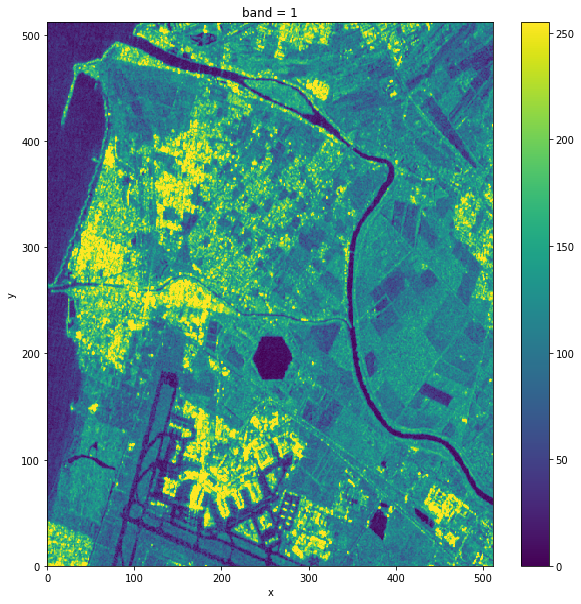

In [42]:
S1GRD.plot(figsize=(10,10))